# Transformer 基础知识


# 第一遍知识总结

- Embedding Space（嵌入空间）
    - 词汇：高维 one-hot 编码
    - Embedding：降低维度操作

- self-attention: 自注意力机制
    - 它通过计算输入序列中不同位置之间的相关性，捕获全局依赖关系
    - 数学机制：
        - 输入：input sequence $X = [x_1,x_2,...,x_n]$, 其中 $x_i$ 是 d-维向量
        - 线性变化：三个向量空间
            - Q：query，查询向量，寻找相关信息
            - K：key，键向量，匹配查询
            - V：value，值向量，生成输出
            - $ Q = XW_Q, K = XW_K, V = XW_V$
            - $W_Q, W_K, W_V$ 是三个可以学习的参数
        - 注意力分数：
            - 对于每个token的位置i，计算其余所有其他位置j的注意力分数：
                $$
                Attetion Score(i,) = (Q_i * K_j) / (sqrt{d_K})
                $$
                - $Q_i$,$K_j$是第i和第j个token的Query和Key向量
                - $d_k$是Key向量的维度，用于缩放以避免数值过大
        - 计算注意力权重：
            - 使用softmax()对注意力分数进行归一化：
            $$
            alpha_{ij} = softmax( (Q_i * K_j) / (sqrt{d_K}))
            $$
        - 注意力权重和所有token的Value向量之间进行加权求和：

- multi-head attention：防止1个attention层无法关注到尽可能多的特征点，使用多个attention得到得多特征点
    - 数学机制：

- The Transformer Network:
    - 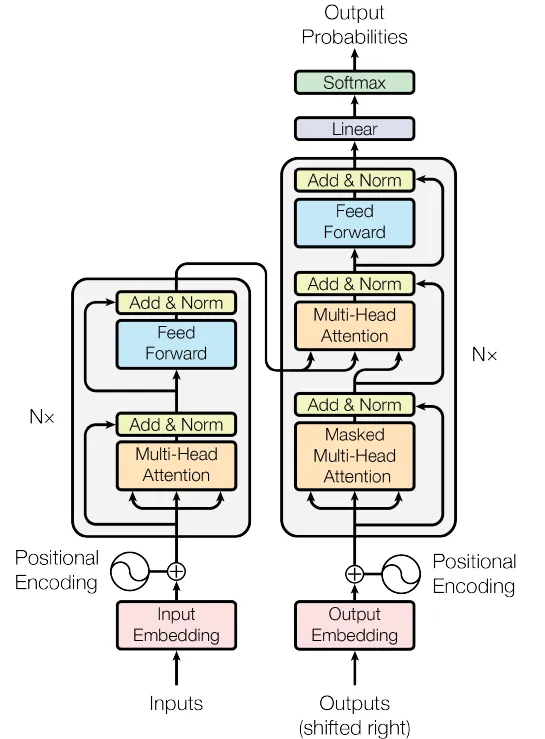
    - 1. The encoder blocks:
        - 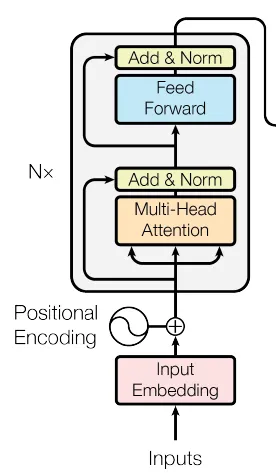
        - 1. input embedding block
            - 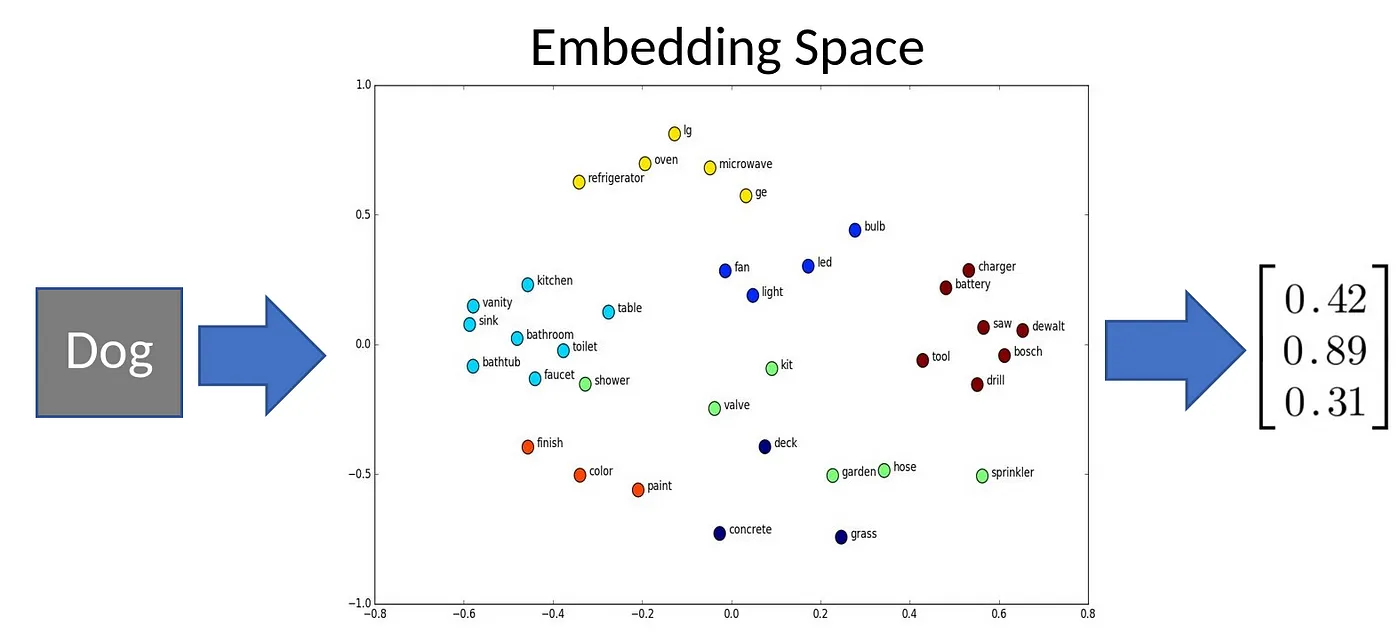
        - 2. position encoding:对于模型而言，可以理解每个word在句子中的位置
            - I own a cute dog (animal/pet — position 5) VS What a lazy dog you are! (worthless -position 4)
            - position encoding: It is a vector that gives information based on the context and position of the word in a sentence.
            - 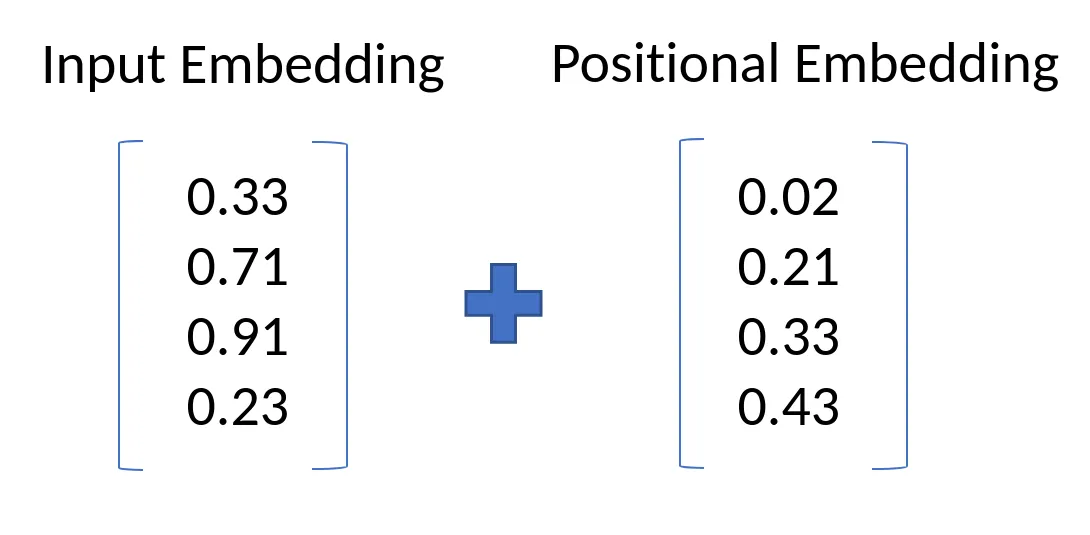
            - 原图使用这种公式来进行位置编码：
            - 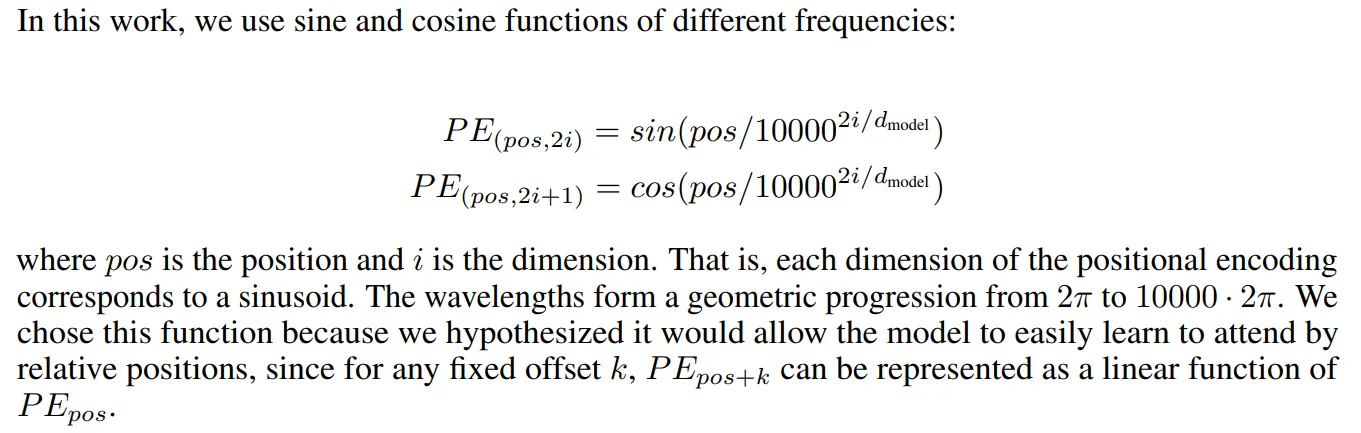
            - 我需要将位置编码的函数结果给可视化出来
        - 3. 多头注意力机制块 Multi-head Attention Blocks:
            - 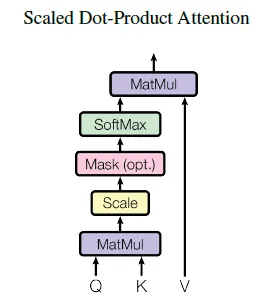
            - 这个注意力机制，是scaled dot-product attention，其实相比于self-attention， 多了Scale层和Mask层，不太理解这两层的作用+数学公式是什么
            - Scale就是缩放，就是除以根号$d_k$
            - Mask层是optional，在translation任务中使用
        - 4. Add & Norm and Feed-Forward
            - Add: 添加残差连接，将position-embedding后的input与multi-head attention的输出concatenate
            - Norm：将output归一化而已
            - Feed-Forward：Feed-Forward（前馈） 是一种神经网络的基本结构形式，信息沿着一个方向流动，从输入层经过隐藏层到输出层，没有反馈连接或循环结构。通常是一个简单的2层全连接网络,FNN之后也会添加 Add & Norm层 
            $$
                FFN(x) = max(0, xW_1+b_1)W_2+b_2
            $$
        - 5. 以上由[multi-head-attention+Add&Norm+FNN+Add&Norm]组成的block，原论文中6块，6块stack

    - 2. The decoder blocks:
        - 结构图：
        - 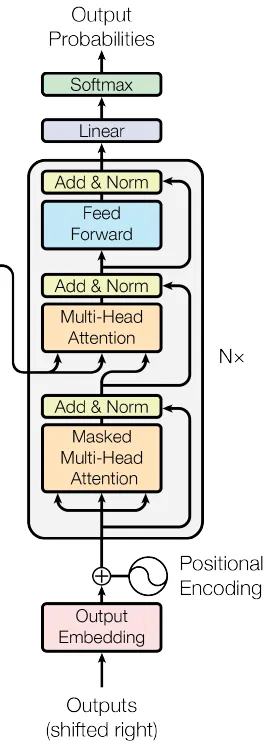
        - 1. word embedding
        - 2. word position encoding
        - 3. 进入 6个循环的blocks:
            - Masked Multi-Head Self-Attention: 
                - 输入的嵌入向量 $X_{tgt}$
                - 计算Query、key、value：
                $$
                Q = X_{tgt}W_Q,  K = X_{tgt}W_K,  V = X_{tgt}W_V
                $$
                - 应用掩码并计算注意力：

            - Multi-Head Cross-Attention
                - 使用目标序列的Query $Q_{tgt}$ 和 Encoder传输过来的Key、Value计算Cross-Attention
                - $$ Q_{tgt} = X_{tgt}W_Q, K_{src} = X_{src}W_k, V_{src} = X_{src}W_V $$
            - FNN
        - 4. Linear layer
        - 5. softmax()
        - 6. compute loss


# Transformer学习-Step1
## 任务描述
学习基础知识，使用pytorch自带的transformer函数，实现最基本的Eng-Gem互译功能

## 任务步骤
- Import necessary libraries and modules
- Define the basic building blocks: Multi-Head Attention, Position-wise Feed-Forward Networks, Positional Encoding
- Build the Encoder and Decoder layers
- Combine Encoder and Decoder layers to create the complete Transformer model
- Prepare sample data
- Train the model
- Test the model


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import copy

# Multi-head attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2,-1)) / math.sqrt(self.d_k) # K.transpose(-2,-1)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9) 
        attn_probs = torch.softmax(attn_scores, dim=-1) #归一化处理的维度
        output = torch.matmul(attn_probs, V)
        return output
    
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1,2) # 作用是什么？

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1,2).contiguous().view(batch_size, seq_length, self.d_model) # 机理不清楚
    
    # 好奇怪的代码
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_Q(Q))
        K = self.split_heads(self.W_K(K))
        V = self.split_heads(self.W_V(V))

        attn_outputs = self.scaled_dot_product_attention(Q,K,V,mask)
        output = self.W_o(self.combine_heads(attn_outputs))
        return output
    # 这里的forward代码应该配上数学公式的解释

# 为何要称之为position-wise
# position-wise feed-forward networks
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward,self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# position-encoding，位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # pe shape : (1, max_seq_length, d_model)
        self.register_buffer('pe', pe.unsqueeze(0)) # self.register_buffer('pe', ...) 将位置编码矩阵 pe 注册为缓冲区

    def forward(self, x):
        # x : (batch_size, seq_length, d_model), 表示一批序列的嵌入向量
        # self.pe[:, :x.size(1)] 提取与当前输入序列长度匹配的部分位置编码。例如，如果 x.size(1) 是 10，则提取 self.pe 的前 10 个位置编码。
        return x + self.pe[:, :x.size(1)]

# The encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    # mask的作用是在训练模型的时候使用的吧，而且特别是在翻译任务当中
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output)) # 我该怎么知道这里应该放入一个dropout？ 原来这个就是 Add&Norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# The decoder layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    # 这一段的参数明显就不懂了
    def forward(self, x, encoder_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))

        cross_output = self.cross_attn(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(x + self.dropout(cross_output))

        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))

        return x

# The Whole Transformer Model
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        # 这个是什么？？
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3) # 为什么要这么做呢？ mask到底是什么呢
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask
    
    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
        
        output = self.fc(dec_output)
        return output

# 准备一些虚假的数据
src_vocab_size = 5000
tgt_vocab_size = 4000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)


criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9,0.98), eps=1e-9)

transformer.train()

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data,tgt_data[:,:-1])
    loss = criterion(
        output.contiguous().view(-1, tgt_vocab_size),
        tgt_data[:, 1:].contiguous().view(-1)
        )
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 8.472051620483398
Epoch: 2, Loss: 8.296442031860352
Epoch: 3, Loss: 8.05046272277832
Epoch: 4, Loss: 7.982245445251465
Epoch: 5, Loss: 7.853405475616455
Epoch: 6, Loss: 7.9975457191467285
Epoch: 7, Loss: 7.985054016113281
Epoch: 8, Loss: 7.960540294647217
Epoch: 9, Loss: 7.911625385284424
Epoch: 10, Loss: 7.702828884124756
Epoch: 11, Loss: 7.64594841003418
Epoch: 12, Loss: 7.952243804931641
Epoch: 13, Loss: 7.7691874504089355
Epoch: 14, Loss: 7.293203830718994
Epoch: 15, Loss: 7.161757469177246
Epoch: 16, Loss: 7.092050075531006
Epoch: 17, Loss: 7.08867073059082


KeyboardInterrupt: 